In [20]:

import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import syndat
import scipy.stats as stat
import matplotlib as mpl
#import syndat.plot as myplt
import sys


sammy_directory =  '/Users/nwx/Documents/GitHub/nuc_syndat/synthetic_data/Ta181' #os.path.realpath('./synthetic_data/Ta181')




In [21]:
%matplotlib notebook

In [105]:
# redux parms ---  experimentally unique values

# =============================================================================
# # constants and uncertainties
# =============================================================================
n = .12 # need to pull this from the endf evaluation
trig = 9760770 # number of linac pulses
flux_mag = 1e5 # what is a reasonable flux magnitude??
detector_efficiency = 1
tof_dist = 35 # m   !!! not the proper tof_distance, but I need the erange to match up

# assuming 1% uncertainty of these values
m1 = 1; dm1 = m1*0.016
m2 = 1; dm2 = m2*0.008
m3 = 1; dm3 = m3*0.018
m4 = 1; dm4 = m4*0.005
alpha = [m1,m2,m3,m4]; d_alpha = [dm1,dm2,dm3,dm4]

a = 582.8061256946647; da = 1.14174241e+03
b = 0.0515158865500879; db = 2.18755273e-05
# a,b COV 1.42405866e-01

# sample in
k_i = 0.563; dk_i = k_i*0.0427
b0_i = 10.0; db0_i = b0_i*0.01
# sample out
K_o = 1.471; dK_o = K_o*0.0379
B0_o = 13.4; dB0_o = B0_o*0.01


# =============================================================================
# # open count rate 
# =============================================================================

# # estimate true underlying, raw, open count data with a wide gaussian flux
# cts_o_true = syndat.exp_effects.generate_open_counts(energy, flux_mag, 50, 100)

# or: import open count rate from RPI Ta-181 experiment:
C_o =pd.read_csv(os.path.join(sammy_directory,'rpi-open-ta181.csv'), sep=',') #pd.read_csv(os.path.join(sammy_directory,'ta181opencountrate.dat'), sep=',')
C_o['E'] = syndat.exp_effects.t_to_e(C_o['tof']*1e-6, tof_dist, True) 
# C_o['E'] = pd.read_csv(os.path.join(sammy_directory,'ta-181-12mm.twenty'), sep='\s+', names=['E','1','2'])['E']

# ctr_o_true = C_o['co'][0:-5] # C_o.loc[C_o['E'] < 330, 'co']
# tof = C_o['tof'][0:-5] # C_o.loc[C_o['E'] < 330, 'tof'] *1e-6  #!!! tof must be in microseconds to have the proper magnitude that Jesse normed to
# energy = C_o['E'][0:-5]
cts_o_true = C_o['counts'][0:-5] # C_o.loc[C_o['E'] < 330, 'co']
tof = C_o['tof'][0:-5] # C_o.loc[C_o['E'] < 330, 'tof'] *1e-6  #!!! tof must be in microseconds to have the proper magnitude that Jesse normed to
energy = C_o['E'][0:-5]

# get ben width vector from tof
# bw = np.flipud(np.diff(np.flipud(tof)))
# bw = np.insert(bw,0,bw[0]) # assumes given leading tof edge
bw = C_o['bin_width'][0:-5]*1e-6

# background function - Jesse has normalized alread, tof mus be micro-seconds
def bkg_func(ti,a,b):
    return a*np.exp(ti*-b)
Bi = bkg_func(tof,a,b)


# =============================================================================
# 
# #plt.plot(C_o['tof'], C_o['co'])
# plt.plot(tof, ctr_o_true)
# plt.xlabel('tof'); plt.ylabel('countrate')
# plt.yscale('log'); plt.xscale('log')
# plt.show(); plt.close()
# =============================================================================


# get open counts - no need to propagate uncertainty bc we are un-reducing - taking these input values as truth
#cts_o_true = ctr_o_true*bw*trig

#C_o
bw

0        8.192000e-07
1        8.192000e-07
2        8.192000e-07
3        8.192000e-07
4        8.192000e-07
             ...     
16040    2.621440e-05
16041    2.621440e-05
16042    2.621440e-05
16043    5.242880e-05
16044    5.242880e-05
Name: bin_width, Length: 16045, dtype: float64

<IPython.core.display.Javascript object>


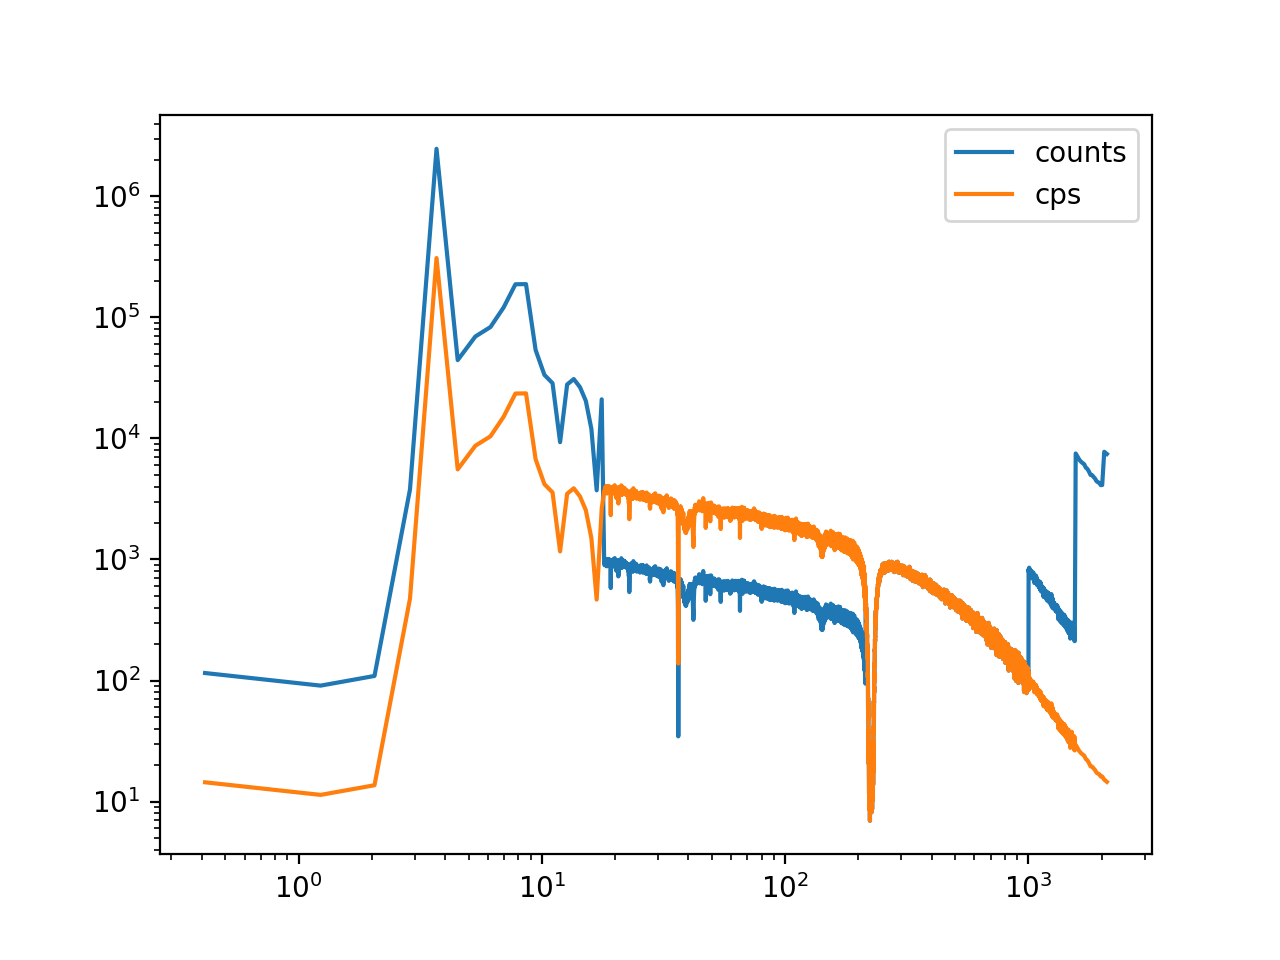

In [106]:
plt.figure()
plt.plot(tof,cts_o_true, label='counts')
plt.plot(tof,cts_o_true/(bw*trig), label='cps')
plt.yscale('log');plt.xscale('log')
plt.legend()


In [107]:
#%% read sammy lst for experimentally corrected theoretical cross section

sam = syndat.sammy_interface.readlst(os.path.join(sammy_directory,'SAMMY.LST'))

# could test that energy structure lines up the same
# energy = sam['E'] 

T_theo = sam['theo_trans']

<IPython.core.display.Javascript object>


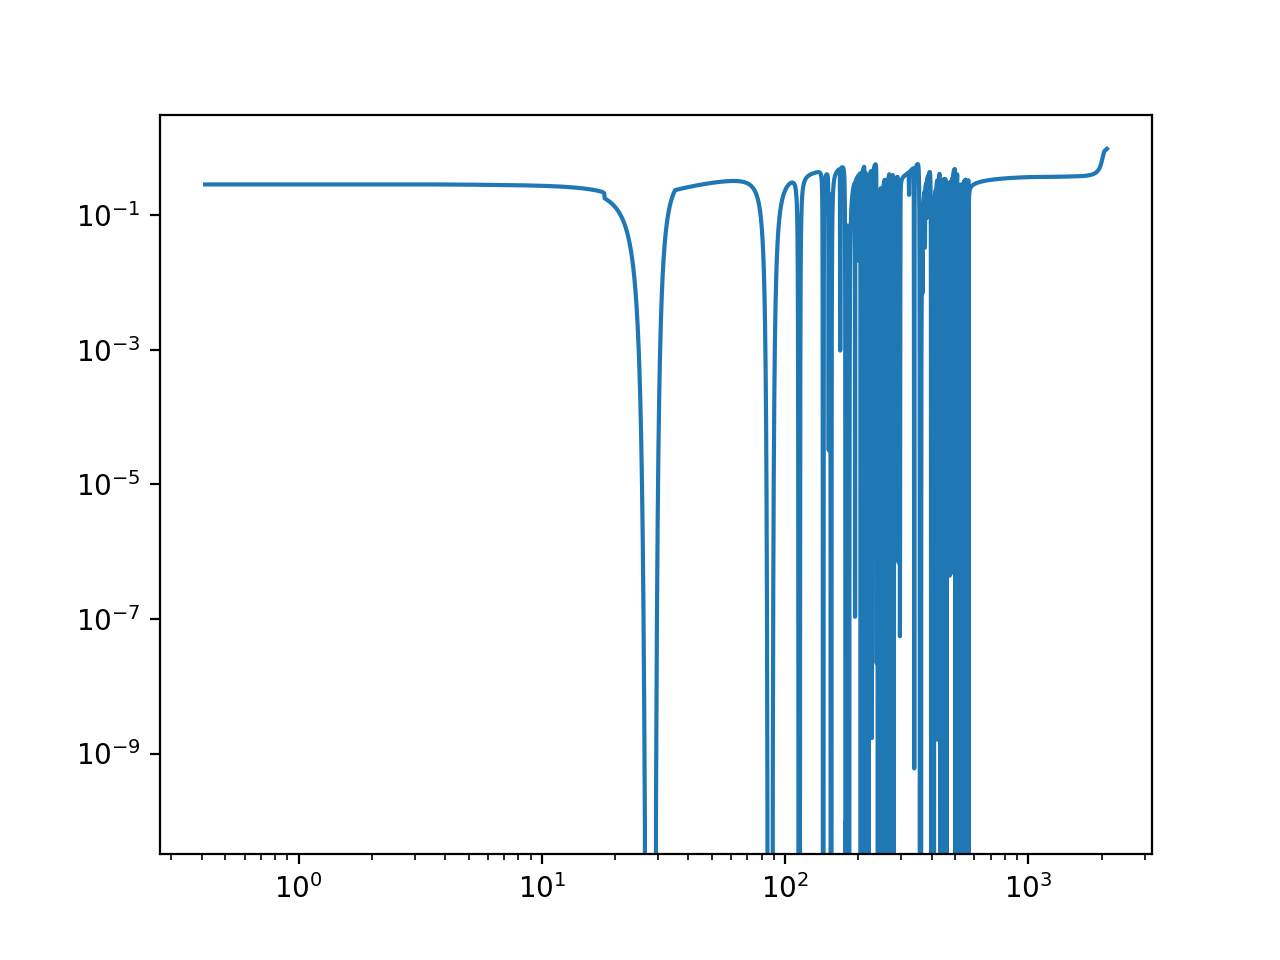

In [109]:
plt.figure()
plt.plot(tof,T_theo)
plt.xscale('log'); plt.yscale('log')

<IPython.core.display.Javascript object>


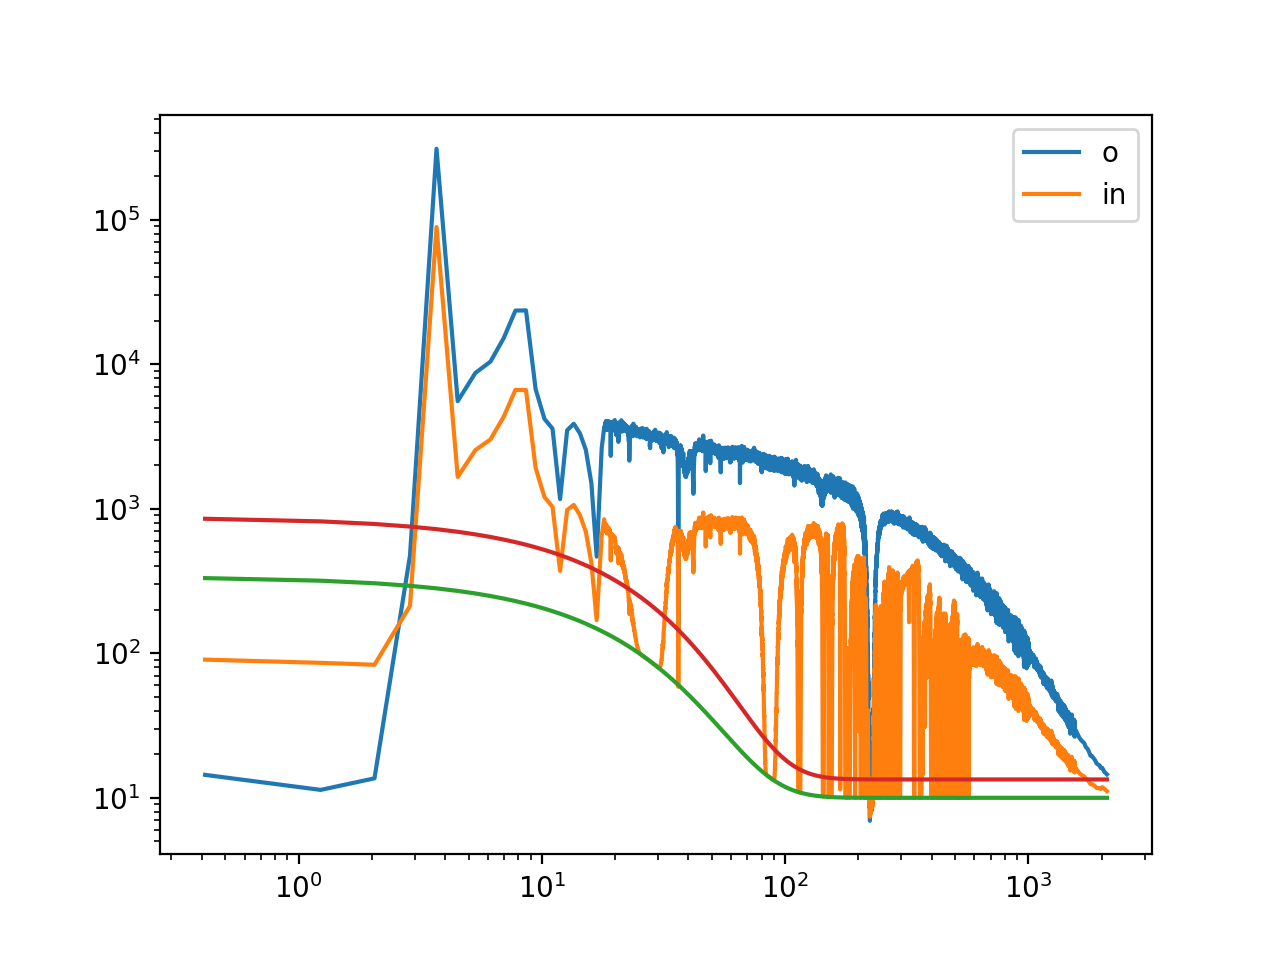

In [121]:
#%%
# =============================================================================
# # generate noisy, raw, sample in count data with statistical unc from a true underlying transmission
# =============================================================================

#noisy_cts_i, noisy_cts_i_se, cts_i, cts_i_se = syndat.exp_effects.generate_raw_count_data(energy, T_theo, cts_o_true, bw, trig, k_i,K_o, Bi, b0_i,B0_o, alpha)

#calculate open count rates
Cr, dCr = syndat.exp_effects.cts_to_ctr(cts_o_true, np.sqrt(cts_o_true), bw, trig) # cts_o/(bw*trig)

# calculate sample in count rate from theoretical transmission, bkg, m,k, and open count rate
[m1,m2,m3,m4] = alpha
cr = (T_theo*(m3*Cr - m4*K_o*Bi - B0_o) + m2*k_i*Bi + b0_i)/m1

# calculate sample in counts, noise, and uncertainty
c = cr*bw*trig 
dc = np.sqrt(c)
nc = syndat.exp_effects.gaus_noise(c,dc) # will create some negative counts, force to zero
nc = np.where(nc<0, 0, nc) # replace negative counts with 0
dnc = np.sqrt(nc)


# take a noisy measurement of raw open count data with uncertainty
cts_o = cts_o_true # syndat.exp_effects.generate_open_counts(energy, flux_mag, 50, 100)
cts_o_se = np.sqrt(cts_o) # statistical error from poisson counting stats
noisy_cts_o = syndat.exp_effects.gaus_noise(cts_o, cts_o_se)
noisy_cts_o_se = np.sqrt(noisy_cts_o)

plt.figure()
plt.plot(tof,Cr, label='o')
plt.plot(tof,cr, label='in')
plt.plot(tof, k_i*Bi + b0_i)
plt.plot(tof, K_o*Bi + B0_o)
# plt.plot(tof,cts_o_se/cts_o*100, label='o')
# plt.plot(tof,noisy_cts_o_se/noisy_cts_i*100, label='in')
plt.legend()
plt.xscale('log'); plt.yscale('log')




<IPython.core.display.Javascript object>


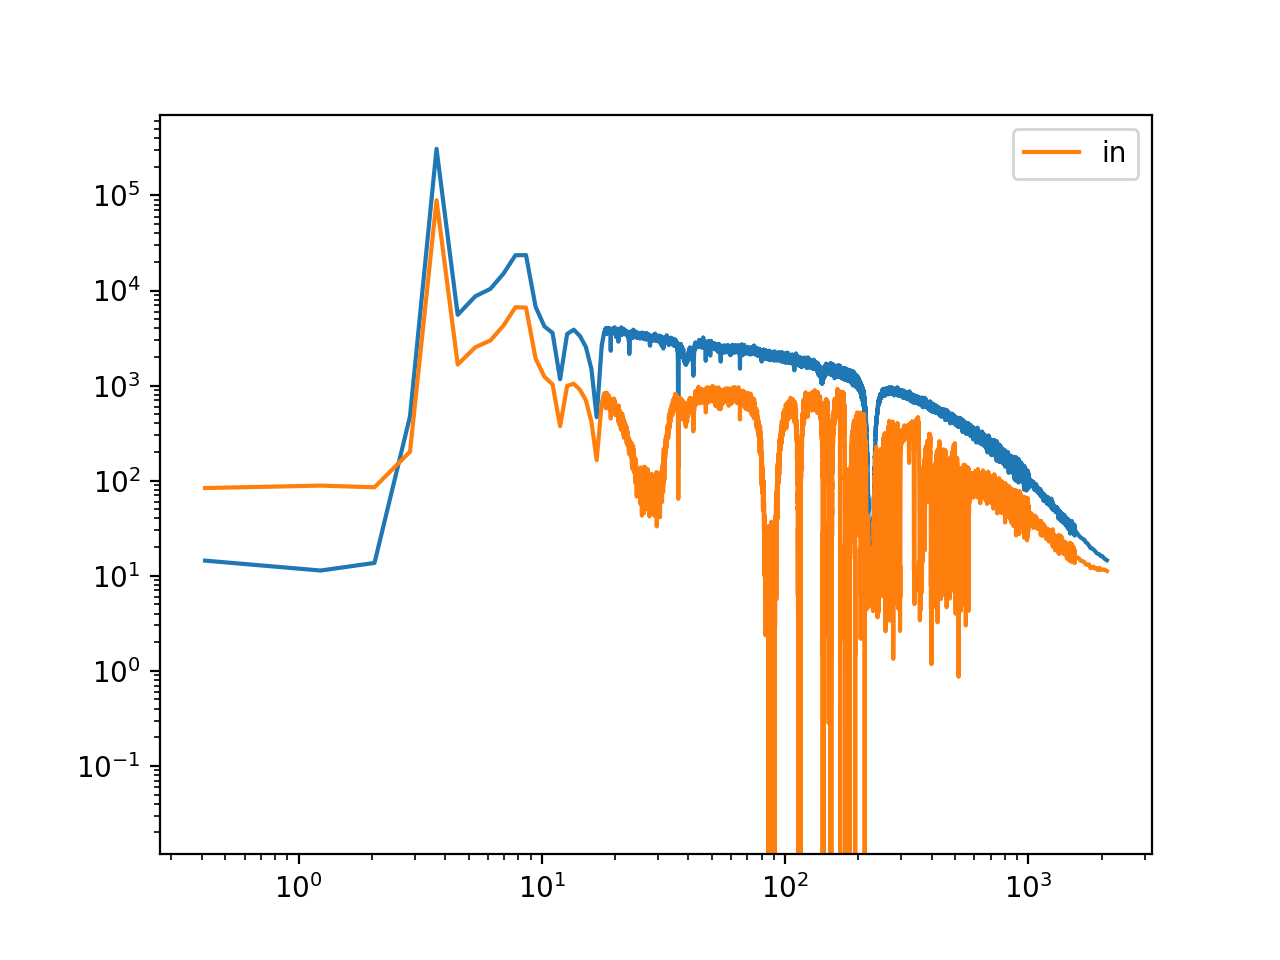

In [117]:
#%% Plotting only

# this section is for plotting only, the next section does these calculations under the hood
# but we want out count rates for plotting

ctr_o, ctr_o_se = syndat.exp_effects.cts_to_ctr(cts_o, cts_o_se, bw, trig) 
ctr_i, ctr_i_se = syndat.exp_effects.cts_to_ctr(noisy_cts_i, noisy_cts_i_se, bw, trig)
Tn = syndat.exp_effects.transmission(ctr_i,ctr_o, Bi, k_i,K_o, b0_i,B0_o, alpha)

#sum(C_o['dco'][0:-5]-ctr_o_se)

#C_o
plt.figure()
plt.plot(tof,ctr_o)
plt.plot(tof,ctr_i, label='in')
plt.legend()
plt.xscale('log'); plt.yscale('log')


<IPython.core.display.Javascript object>


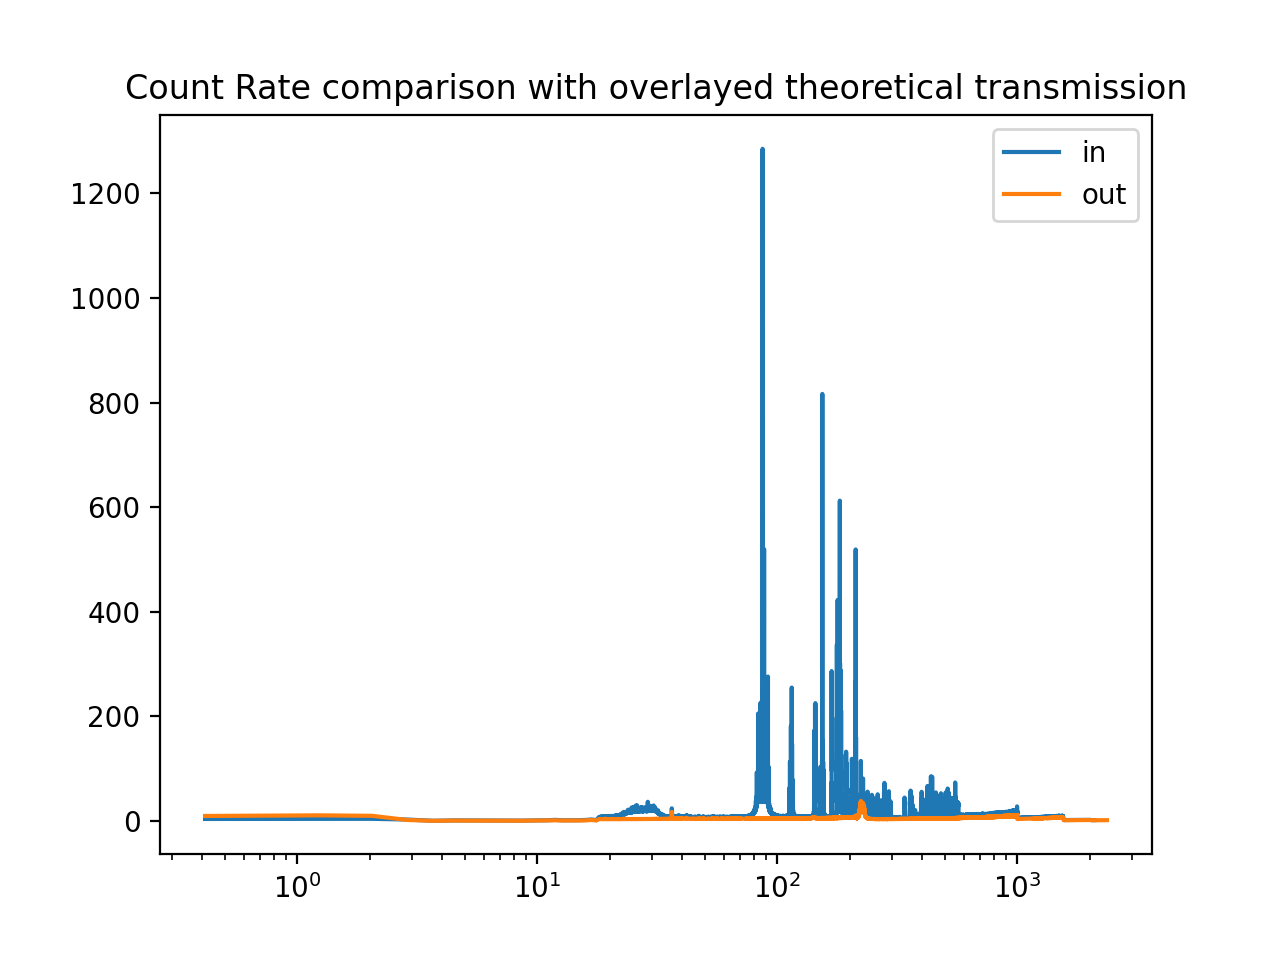

Text(0.5, 1.0, 'Count Rate comparison with overlayed theoretical transmission')

In [95]:
plt.figure()
#plt.errorbar(tof,ctr_i, yerr=ctr_i_se,label='cr_i',color='cornflowerblue',ecolor='cornflowerblue',elinewidth=0.5,capsize=2, fmt='.', ms=1)
#plt.errorbar(tof,ctr_o, yerr=ctr_o_se,color='orange',ecolor='orange',elinewidth=0.5,capsize=2, fmt='.', ms=1)
plt.plot(tof,ctr_i_se/ctr_i*100, label='in')
plt.plot(tof,ctr_o_se/ctr_o*100, label='out')
# plt.plot(tof, ctr_i, lw=1, label='cr_s')
# plt.plot(tof, ctr_o, lw=1, label='cr_o')
# plt.plot(tof, T_theo, label='Theoretical T', c='k', alpha=0.5)

plt.legend()
#plt.ylim([1e-3,1e5])
#plt.xlim([2e2, 2.5e2])
plt.xscale('log'); #plt.yscale('log')

plt.title('Count Rate comparison with overlayed theoretical transmission')
#plt.show(); plt.close()




array([nan, nan, nan, ..., nan, nan, nan])

In [76]:
#%% Reduce the noisy, raw count data


# compile systematic uncertainties
sys_unc = np.append([da,db,dk_i,dK_o,db0_i,dB0_o], d_alpha)

%time
#%%timeit
# reduce raw, noisy count data with statistical uncertainties to transmission data with propagated uncertainty
Tn, dT, CovT = syndat.exp_effects.reduce_raw_count_data(tof, noisy_cts_i,noisy_cts_o, noisy_cts_i_se,noisy_cts_o_se, \
                                                        bw, trig, a,b, k_i,K_o, Bi, b0_i,B0_o, alpha, sys_unc)
# calculate the correlation matrix
CorT = np.corrcoef(CovT)


<IPython.core.display.Javascript object>


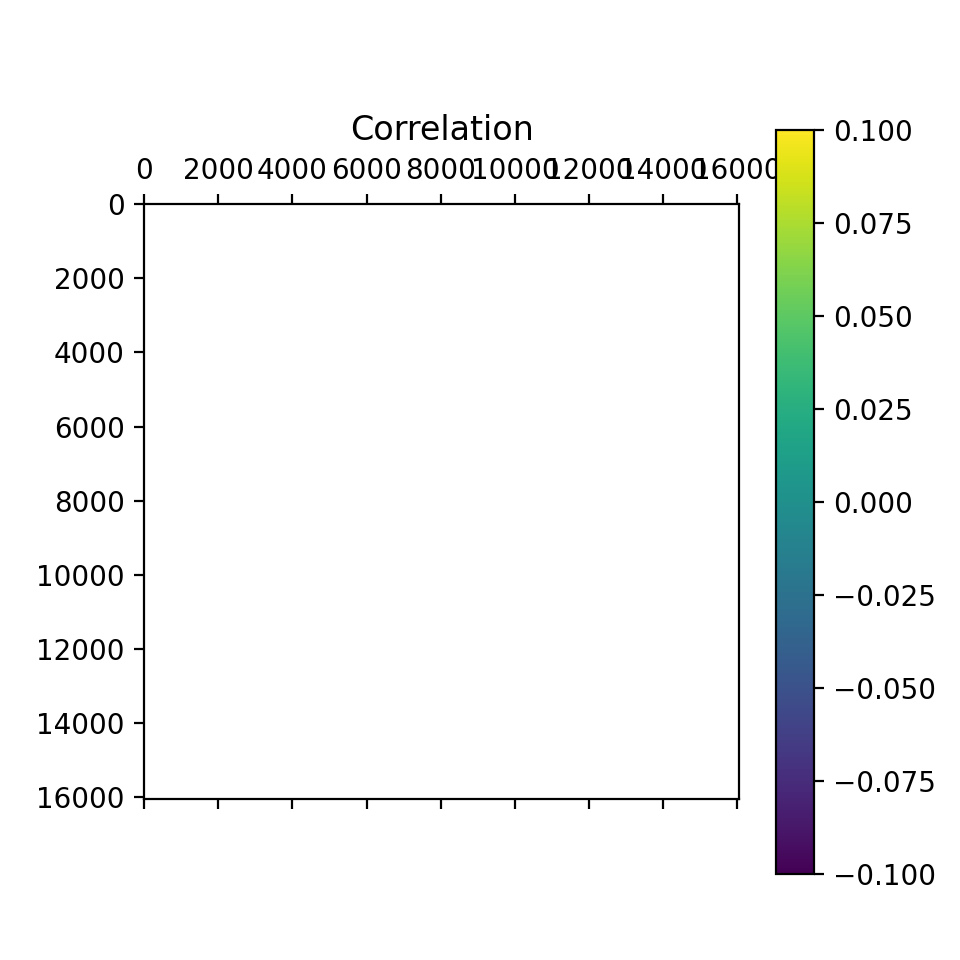

Text(0.5, 1.0, 'Correlation')

In [77]:
#%%

plt.matshow(CorT)
ax = plt.gca()

# ax.set_xticklabels(round(ax.get_xticks()), rotation = 45)
cb = plt.colorbar()
plt.title('Correlation')

# plt.show(); plt.close()

In [81]:

#plt.rcParams.update(plt.rcParamsDefault)


array([nan, nan, nan, ..., nan, nan, nan])

In [78]:
syndat.plot.exp_theo(tof, Tn, dT, T_theo)

ValueError: x and y must have same first dimension, but have shapes (16050,) and (16045,)

<IPython.core.display.Javascript object>


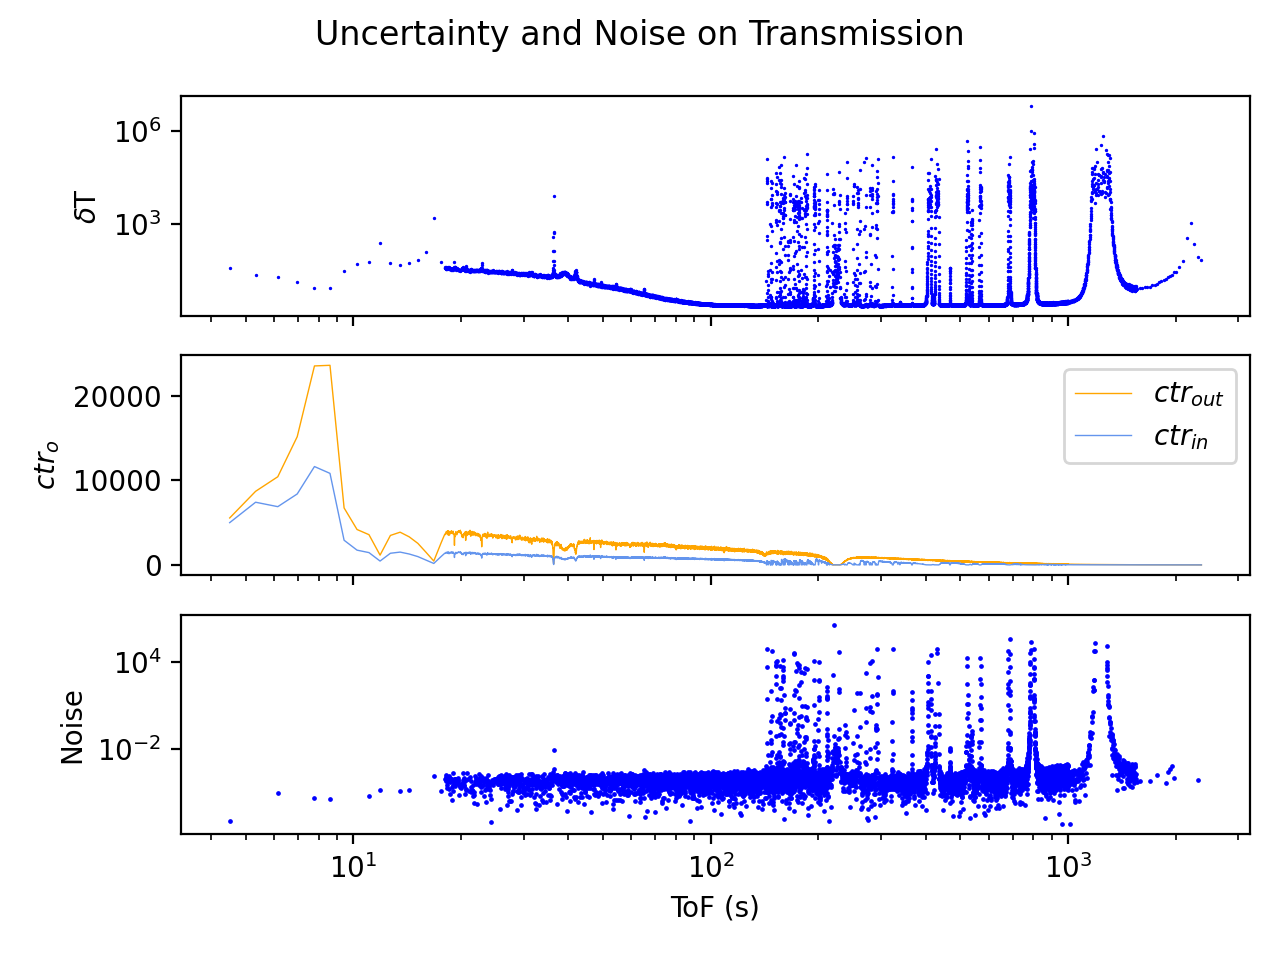

In [22]:
syndat.plot.unc_noise(tof, dT, T_theo, Tn, ctr_o, ctr_i)

In [14]:
plt.errorbar(tof,Tn, yerr=dT,color='k',ecolor='k',elinewidth=0.5,capsize=2, fmt='.', ms=1)
#plt.scatter(tof, Tn, label='Experimental', s=1, c='k')
plt.plot(tof, T_theo, label='Theoretical', c='g', lw=0.25)
#plt.legend()
plt.ylim([-.1,1.5])
# #plt.xlim([1e2,1e3])
plt.xscale('log')
#plt.yscale('log')


/var/folders/cc/89xj9rjn3nj1dhd6m66j11y9jj17p5/T/ipykernel_49350/4217875917.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([-.1,1.5])
